In [202]:
import pandas as pd
import numpy as np
import requests
import os
import time
import matplotlib.pyplot as plt

In [203]:
coin_name = 'xrp'
unit = 'usd'

filename="tiingo_%s.csv"%coin_name
coin = pd.read_csv(filename)
# coin.Date = pd.to_datetime(coin.Date)

In [204]:
def convert_GMT(date):
    # convert date value from BITX data to utc time
    return pd.to_datetime(date[:-8]).tz_localize('US/Eastern').tz_convert('UTC')
    

In [217]:
filename= 'CRIX_hourly_Tiingo.csv'
coin_name = 'CRIX'

coin = pd.read_csv(filename, error_bad_lines=False)
coin.columns = ['Date', 'open', 'high', 'low', 'close'] # for CRIX hourly data

coin.Date = pd.to_datetime(coin.Date)
coin = coin.loc[:,['Date', 'close']]

coin.columns = ['Date', '%s Price' %coin_name]
# coin.Date = coin.Date.apply(convert_GMT)

In [218]:
future = pd.read_pickle('../../data/btc future and reference rate/concated_cleaned_bbt_future.pkl')

merged = future.merge(coin, on = 'Date', how='inner')
merged = merged.drop_duplicates()

merged.PX_LAST = merged.PX_LAST.astype('float')
merged.loc[:, '%s Price'%coin_name] = merged.loc[:, '%s Price'%coin_name].astype('float')

merged.loc[:, 'log return future'] = np.log(merged.PX_LAST/merged.PX_LAST.shift(-1))
merged.loc[:, 'log return %s'%coin_name] = np.log(merged.loc[:, '%s Price'%coin_name]/merged.loc[:,'%s Price'%coin_name].shift(-1))

merged = merged.iloc[:-1,:]

rs = merged.loc[:, 'log return %s'%coin_name]
rf = merged.loc[:, 'log return future']

from statsmodels.distributions.empirical_distribution import ECDF

ecdf_rs = ECDF(rs)
ecdf_rf = ECDF(rf)
ecdf_rh = ECDF(rs-rf)

m = min([np.min(rs), np.min(rf)])
M = max([np.max(rs), np.max(rf)])

In [219]:
merged

,Date,PX_LAST,contract_name,CRIX Price,log return future,log return CRIX
0,2021-05-27 20:00:00+00:00,38865.0,BTCM1 Curncy,4196.136061,0.006583,-0.015700
1,2021-05-26 20:00:00+00:00,38610.0,BTCM1 Curncy,4262.536211,0.032643,0.053698
2,2021-05-25 20:00:00+00:00,37370.0,BTCM1 Curncy,4039.685323,-0.062245,-0.031494
3,2021-05-24 20:00:00+00:00,39770.0,BTCM1 Curncy,4168.935191,0.094330,0.109357
4,2021-05-21 20:00:00+00:00,36190.0,BTCM1 Curncy,3737.075707,-0.108809,-0.157647
...,...,...,...,...,...,...
743,2018-06-08 20:00:00+00:00,7675.0,BTCN18 Curncy,1049.023655,-0.005846,-0.003306
744,2018-06-07 20:00:00+00:00,7720.0,BTCN18 Curncy,1052.497881,0.022267,0.004723
745,2018-06-06 20:00:00+00:00,7550.0,BTCN18 Curncy,1047.538361,-0.012504,-0.006511
746,2018-06-05 20:00:00+00:00,7645.0,BTCN18 Curncy,1054.380695,0.017151,0.018149


In [8]:
merged = merged.iloc[:,[0,1,2,4,5,6]]

In [220]:
# merged.to_csv('../../data/cleaned_data/BBT_future_Tiingo_%s.csv'%coin_name)
merged.to_csv('../../data/cleaned_data/BBT_future_%s.csv'%coin_name)

Text(0, 0.5, 'Future(CME BTC)')

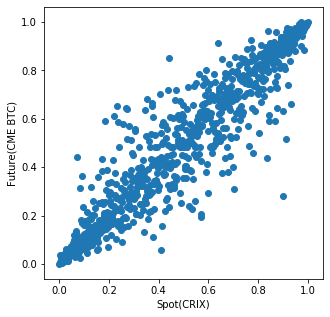

In [221]:
plt.figure(figsize=(5,5))
plt.scatter(ecdf_rs(rs), ecdf_rf(rf))
plt.xlabel('Spot(%s)'%coin_name)
plt.ylabel('Future(CME BTC)')

In [168]:
test = merged.iloc[:300, :]
train = merged.iloc[300:600, :]

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [169]:
import os, sys
sys.path.append('../../src/')
from KDEs import *
from copulae1 import *
from toolbox import *
import os

In [170]:
rs = train.loc[:, 'log return %s'%coin_name]
rf = train.loc[:, 'log return future']

kde_btc_future = KDE(rf, "Gaussian")
kde_eth = KDE(rs, "Gaussian")

u = ECDF(rs)(rs)
v = ECDF(rf)(rf)

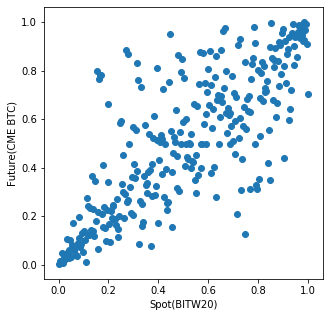

In [171]:
plt.figure(figsize=(5,5))
plt.xlabel('Spot(%s)'%coin_name)
plt.ylabel('Future(CME BTC)')
plt.scatter(u,v)

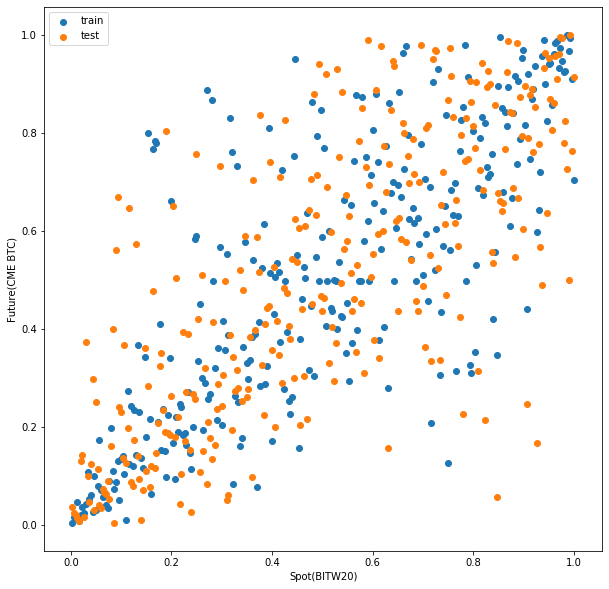

In [172]:
rs_test = test.loc[:, 'log return %s'%coin_name]
rf_test = test.loc[:, 'log return future']

u_test = ECDF(rs_test)(rs_test)
v_test = ECDF(rf_test)(rf_test)

plt.figure(figsize=(10,10))
plt.xlabel('Spot(%s)'%coin_name)
plt.ylabel('Future(CME BTC)')
plt.scatter(u,v, label='train')
plt.scatter(u_test,v_test, label='test')
plt.legend()

In [173]:
C1 = Gaussian({'rho':0.9}, kde_eth, kde_btc_future)

C2 = t_Copula({'rho':0.9, 'nu':4}, kde_eth, kde_btc_future, 2)

C3 = Clayton({'theta':1}, kde_eth, kde_btc_future)




# C1.canonical_calibrate(u,v)
# C2.canonical_calibrate(u,v)
# C3.canonical_calibrate(u,v)

q_arr = [0.01,0.05,0.95,0.99]
C1.mm_calibrate(u,v,q_arr)
C2.mm_calibrate(u,v,q_arr)
C3.mm_calibrate(u,v,q_arr)

../../src/copulae1.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m_hat = np.array([self.tau()] + [self._lambda(q) for q in q_arr])


Optimization terminated successfully.
         Current function value: 0.058596
         Iterations: 33
         Function evaluations: 70


../../src/toolbox.py:55: RuntimeWarning: overflow encountered in double_scalars
  fn = lambda s: s ** (self.nu - 1) * np.exp(-s ** 2 / 2) * self.MN.cdf(s * b / np.sqrt(self.nu))
../../src/toolbox.py:55: RuntimeWarning: invalid value encountered in double_scalars
  fn = lambda s: s ** (self.nu - 1) * np.exp(-s ** 2 / 2) * self.MN.cdf(s * b / np.sqrt(self.nu))
../../src/toolbox.py:56: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return 2 ** (1 - (self.nu / 2)) / gamma(self.nu / 2) * scipy.integrate.quad(fn, 0, np.inf)[0]


Optimization terminated successfully.
         Current function value: 0.059699
         Iterations: 151
         Function evaluations: 289
Optimization terminated successfully.
         Current function value: 0.346944
         Iterations: 35
         Function evaluations: 74


array([1.61684647])

In [174]:
print('\n',
      C1.paras, '\n', 
      C2.paras, '\n',
      C3.paras)


 {'rho': 0.8193172410875558} 
 {'rho': 0.8156750407972365, 'nu': 87.26513210264423} 
 {'theta': 1.6168464660644548}


In [175]:
print('\n',
      C1.paras, '\n', 
      C2.paras, '\n',
      C3.paras)


 {'rho': 0.8193172410875558} 
 {'rho': 0.8156750407972365, 'nu': 87.26513210264423} 
 {'theta': 1.6168464660644548}


In [176]:
C1.l_fn(C1.paras['rho'], u,v)

../../src/copulae1.py:116: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(np.log(part1 / part2))


0.5310553458164042

In [177]:
C2.l_fn(C2.paras['rho'],C2.paras['nu'], u,v)

0.5347987901732218

In [178]:
k_arr = [10]
q_arr_ES = [0.01,0.05]
q_arr_VaR = [0.01,0.05]

h1_arr = optimize_h(C1, k_arr, q_arr_ES, q_arr_VaR)

Optimization terminated successfully.
         Current function value: 0.001164
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.057734
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.140744
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.087666
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.102648
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.057769
         Iterations: 14
         Function evaluations: 29


In [179]:
h2_arr = optimize_h(C2, k_arr, q_arr_ES, q_arr_VaR)

Optimization terminated successfully.
         Current function value: 0.001178
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.058031
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.141464
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.088109
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.103163
         Iterations: 13
         Function evaluations: 27
Optimization terminated successfully.
         Current function value: 0.058043
         Iterations: 13
         Function evaluations: 29


In [180]:
k_arr = [10]
q_arr_ES = [0.01,0.05]
q_arr_VaR = [0.01,0.05]

h3_arr = optimize_h(C3, k_arr, q_arr_ES, q_arr_VaR)

Optimization terminated successfully.
         Current function value: 0.001742
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.064999
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.138765
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.095235
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.114601
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.067177
         Iterations: 15
         Function evaluations: 32


In [181]:
print('%.3f'%h1_arr[0], '%.3f'%h1_arr[1], '%.3f'%h1_arr[2], '%.3f'%h1_arr[3], '%.3f'%h1_arr[4], '%.3f'%h1_arr[5])
print('%.3f'%h2_arr[0], '%.3f'%h2_arr[1], '%.3f'%h2_arr[2], '%.3f'%h2_arr[3], '%.3f'%h2_arr[4], '%.3f'%h2_arr[5])
print('%.3f'%h3_arr[0], '%.3f'%h3_arr[1], '%.3f'%h3_arr[2], '%.3f'%h3_arr[3], '%.3f'%h3_arr[4], '%.3f'%h3_arr[5])

0.822 0.863 0.988 0.910 0.907 0.796
0.818 0.860 0.985 0.908 0.887 0.788
0.679 0.643 0.704 0.639 0.600 0.636


In [182]:
rs_test = test.iloc[:,-1]
rf_test = test.iloc[:,-2]

In [183]:
VaR95_1 = np.quantile(rs - h1_arr[5]*rf, 0.05)
VaR95_2 = np.quantile(rs - h2_arr[5]*rf, 0.05)
VaR95_rs = np.quantile(rs, 0.05)

HE_VaR95_1 = 1-VaR95_1/VaR95_rs 
HE_VaR95_2 = 1-VaR95_2/VaR95_rs 

print(HE_VaR95_1, HE_VaR95_2)

0.3309320824430443 0.33489137401721125


In [184]:
VaR95_1 = np.quantile(rs_test - h1_arr[5]*rf_test, 0.05)
VaR95_2 = np.quantile(rs_test - h2_arr[5]*rf_test, 0.05)
VaR95_rs = np.quantile(rs_test, 0.05)

HE_VaR95_1 = 1-VaR95_1/VaR95_rs 
HE_VaR95_2 = 1-VaR95_2/VaR95_rs 

print(HE_VaR95_1, HE_VaR95_2)

0.31363366759777866 0.3147268149552581


In [185]:
var_1 = np.var(rs - h1_arr[0]*rf)
var_2 = np.var(rs - h2_arr[0]*rf)
var_rs = np.var(rs)

HE_var_1 = 1-var_1/var_rs 
HE_var_2 = 1-var_2/var_rs 
print(HE_var_1, HE_var_2)

0.6534781025867266 0.6532832057747485


In [186]:
var_1 = np.var(rs_test - h1_arr[0]*rf_test)
var_2 = np.var(rs_test - h2_arr[0]*rf_test)
var_rs = np.var(rs_test)

HE_var_1 = 1-var_1/var_rs 
HE_var_2 = 1-var_2/var_rs 
print(HE_var_1, HE_var_2)

0.5037502685270333 0.5036469617609348


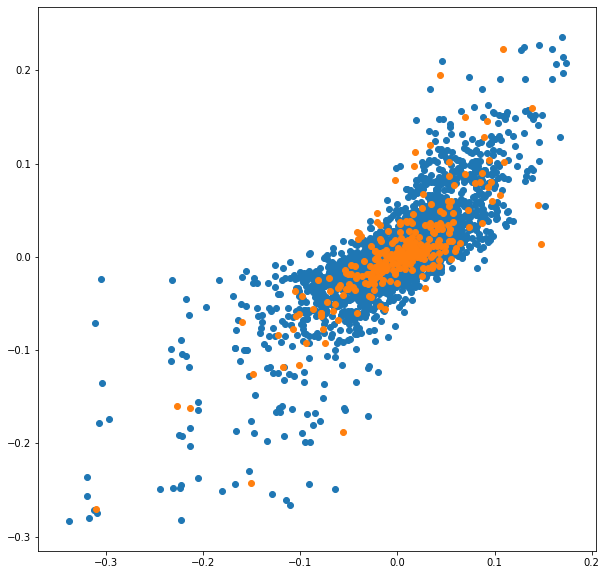

In [187]:
s1 = C1.sample(len(rs)*10)
s2 = C2.sample(len(rf)*10)
plt.figure(figsize=(10,10))
plt.scatter(s1[:,0], s1[:,1])
# plt.scatter(s2[:,0], s2[:,1])
# plt.scatter(rs_test,rf_test)
plt.scatter(rs,rf)

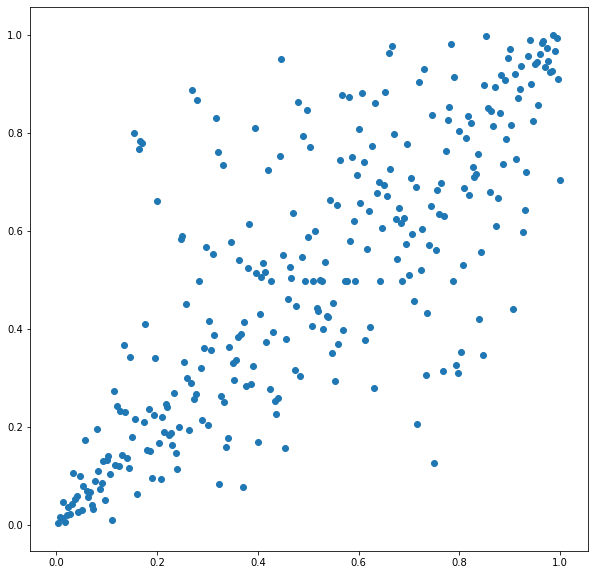

In [188]:
u1s = ECDF(s1[:,0])(s1[:,0])
u1f = ECDF(s1[:,1])(s1[:,1])

u2s = ECDF(s2[:,0])(s2[:,0])
u2f = ECDF(s2[:,1])(s2[:,1])

plt.figure(figsize=(10,10))
# plt.scatter(u1s, u1f)
# plt.scatter(u2s, u2f)
plt.scatter(u,v)

0.8468468468468469


Text(0.5, 0, 'h')

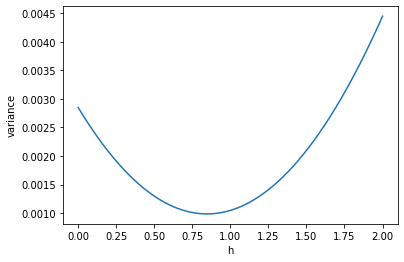

In [189]:
h_arr = np.linspace(0,2,1000)

var_arr = []
for h in h_arr:
    rh = rs - h*rf
    var_arr.append(np.var(rh))
plt.plot(h_arr, var_arr)
print(h_arr[np.argmin(var_arr)])
plt.ylabel('variance')
plt.xlabel('h')

In [190]:
e_h = h_arr[np.argmin(var_arr)]

In [191]:
var_1 = np.var(rs_test - e_h*rf_test)
var_2 = np.var(rs_test - h2_arr[0]*rf_test)
var_rs = np.var(rs_test)

HE_var_1 = 1-var_1/var_rs 
HE_var_2 = 1-var_2/var_rs 
print(HE_var_1, HE_var_2)

0.5038737466693956 0.5036469617609348


0.8468468468468469


Text(0.5, 1.0, 'Variance of rh, in-sample')

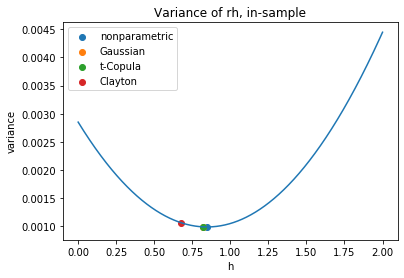

In [192]:
plt.plot(h_arr, var_arr)
print(h_arr[np.argmin(var_arr)])
plt.ylabel('variance')
plt.xlabel('h')

plt.scatter([e_h], [np.var(rs-e_h*rf)], label='nonparametric')
plt.scatter([h1_arr[0]], [np.var(rs-h1_arr[0]*rf)], label='Gaussian')
plt.scatter([h2_arr[0]], [np.var(rs-h2_arr[0]*rf)], label='t-Copula')
plt.scatter([h3_arr[0]], [np.var(rs-h3_arr[0]*rf)], label='Clayton')

plt.legend()
plt.title('Variance of rh, in-sample')

0.8368368368368369


Text(0.5, 1.0, 'Variance of rh, out-of-sample')

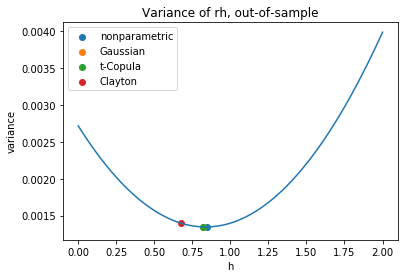

In [193]:
var_arr = []
for h in h_arr:
    rh = rs_test - h*rf_test
    var_arr.append(np.var(rh))

plt.plot(h_arr, var_arr)
print(h_arr[np.argmin(var_arr)])
plt.ylabel('variance')
plt.xlabel('h')

plt.scatter([e_h], [np.var(rs_test-e_h*rf_test)], label='nonparametric')
plt.scatter([h1_arr[0]], [np.var(rs_test-h1_arr[0]*rf_test)], label='Gaussian')
plt.scatter([h2_arr[0]], [np.var(rs_test-h2_arr[0]*rf_test)], label='t-Copula')
plt.scatter([h3_arr[0]], [np.var(rs_test-h3_arr[0]*rf_test)], label='Clayton')

plt.legend()
plt.title('Variance of rh, out-of-sample')

0.4444444444444444


Text(0.5, 0, 'h')

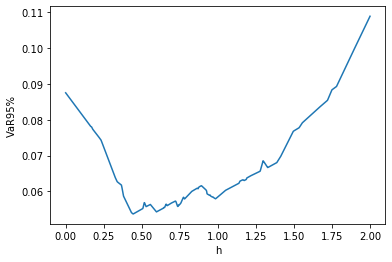

In [194]:
# h_arr = np.linspace(0,1,1000)

VaR95_arr = []
for h in h_arr:
    rh = rs - h*rf
    VaR95_arr.append(-np.quantile(rh, 0.05))
plt.plot(h_arr, VaR95_arr)

e_h = h_arr[np.argmin(VaR95_arr)]

print(h_arr[np.argmin(VaR95_arr)])
plt.ylabel('VaR95%')
plt.xlabel('h')

In [195]:
VaR95_1 = np.quantile(rs_test - e_h*rf_test, 0.05)
VaR95_2 = np.quantile(rs_test - h2_arr[5]*rf_test, 0.05)
VaR95_rs = np.quantile(rs_test, 0.05)

HE_VaR95_1 = 1-VaR95_1/VaR95_rs 
HE_VaR95_2 = 1-VaR95_2/VaR95_rs

print(HE_VaR95_1, HE_VaR95_2)

0.2810106172515947 0.3147268149552581


Text(0.5, 1.0, 'VaR95% of rh, out-of-sample')

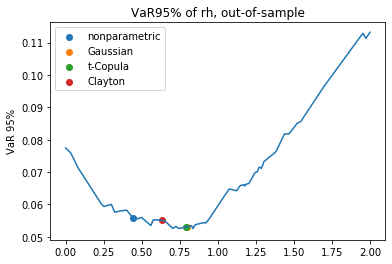

In [196]:
VaR95_arr = []
for h in h_arr:
    rh = rs_test - h*rf_test
    VaR95_arr.append(-np.quantile(rh, 0.05))
plt.plot(h_arr, VaR95_arr)

plt.scatter([e_h], [-np.quantile(rs_test-e_h*rf_test, 0.05)], label='nonparametric')
plt.scatter([h1_arr[5]], [-np.quantile(rs_test-h1_arr[5]*rf_test, 0.05)], label='Gaussian')
plt.scatter([h2_arr[5]], [-np.quantile(rs_test-h2_arr[5]*rf_test, 0.05)], label='t-Copula')
plt.scatter([h3_arr[5]], [-np.quantile(rs_test-h3_arr[5]*rf_test, 0.05)], label='Clayton')

plt.legend()
plt.ylabel('VaR 95%')
plt.title('VaR95% of rh, out-of-sample')

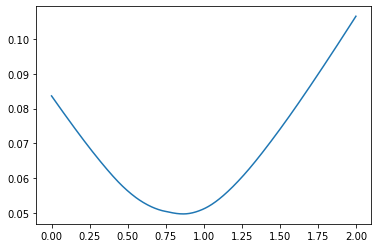

In [197]:
ERM_arr = []
for h in h_arr:
    rh = rs - h*rf
    risk = ERM_estimate_trapezoidal(10, rh)
    ERM_arr.append(risk)
    
plt.plot(h_arr, ERM_arr)

In [198]:
e_h = h_arr[np.argmin(ERM_arr)]
e_h

0.8648648648648649

Text(0.5, 1.0, 'ERM of rh, out-of-sample')

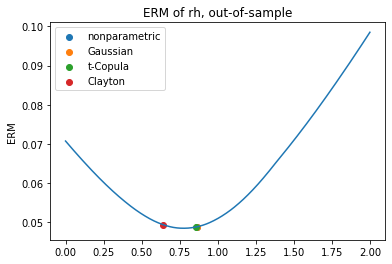

In [199]:
ERM_arr = []
for h in h_arr:
    rh = rs_test - h*rf_test
    risk = ERM_estimate_trapezoidal(10, rh)
    ERM_arr.append(risk)
    
plt.plot(h_arr, ERM_arr)

plt.scatter([e_h], [ERM_estimate_trapezoidal(10,rs_test-e_h*rf_test)], label='nonparametric')
plt.scatter([h1_arr[1]], [ERM_estimate_trapezoidal(10,rs_test-h1_arr[1]*rf_test)], label='Gaussian')
plt.scatter([h2_arr[1]], [ERM_estimate_trapezoidal(10, rs_test-h2_arr[1]*rf_test)], label='t-Copula')
plt.scatter([h3_arr[1]], [ERM_estimate_trapezoidal(10,rs_test-h3_arr[1]*rf_test)], label='Clayton')

plt.legend()
plt.ylabel('ERM')
plt.title('ERM of rh, out-of-sample')

0.7747747747747747


Text(0.5, 0, 'h')

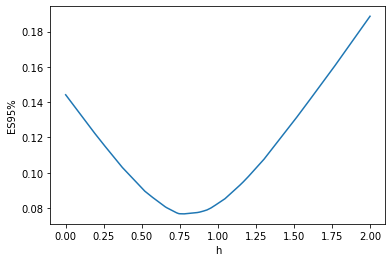

In [200]:
# h_arr = np.linspace(0,1,1000)

ES95_arr = []
for h in h_arr:
    rh = rs - h*rf
    ES95_arr.append(ES(0.05, rh))
plt.plot(h_arr, ES95_arr)

e_h = h_arr[np.argmin(ES95_arr)]

print(h_arr[np.argmin(ES95_arr)])
plt.ylabel('ES95%')
plt.xlabel('h')

Text(0.5, 1.0, 'ES95% of rh, out-of-sample')

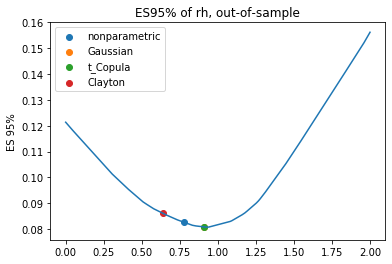

In [201]:
ES95_arr = []
for h in h_arr:
    rh = rs_test - h*rf_test
    ES95_arr.append(ES(0.05,rh))
plt.plot(h_arr, ES95_arr)

plt.scatter([e_h], [ES(0.05, rs_test-e_h*rf_test)], label='nonparametric')
plt.scatter([h1_arr[3]], [ES(0.05, rs_test-h1_arr[3]*rf_test)], label='Gaussian')
plt.scatter([h2_arr[3]], [ES(0.05, rs_test-h2_arr[3]*rf_test)], label='t_Copula')
plt.scatter([h3_arr[3]], [ES(0.05, rs_test-h3_arr[3]*rf_test)], label='Clayton')

plt.legend()
plt.ylabel('ES 95%')
plt.title('ES95% of rh, out-of-sample')